C:\Users\GCU\AppData\Local\Temp\ipykernel_23520\2516552128.py:105: RuntimeWarning: divide by zero encountered in scalar power
  D_particle = 1.95 * D2 * (1.293 / rho)**(-1/6) * (We**(-1/3))


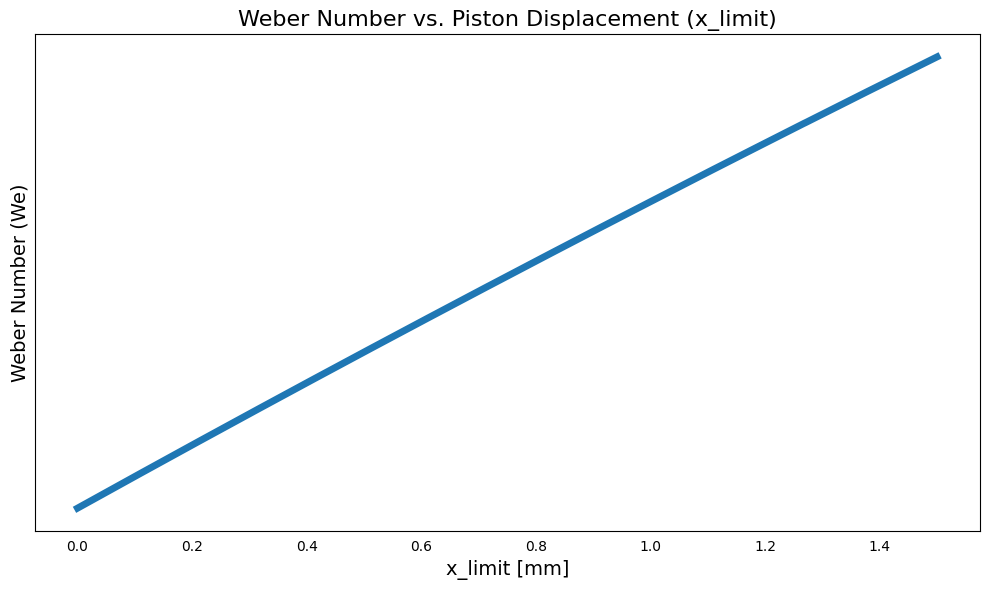

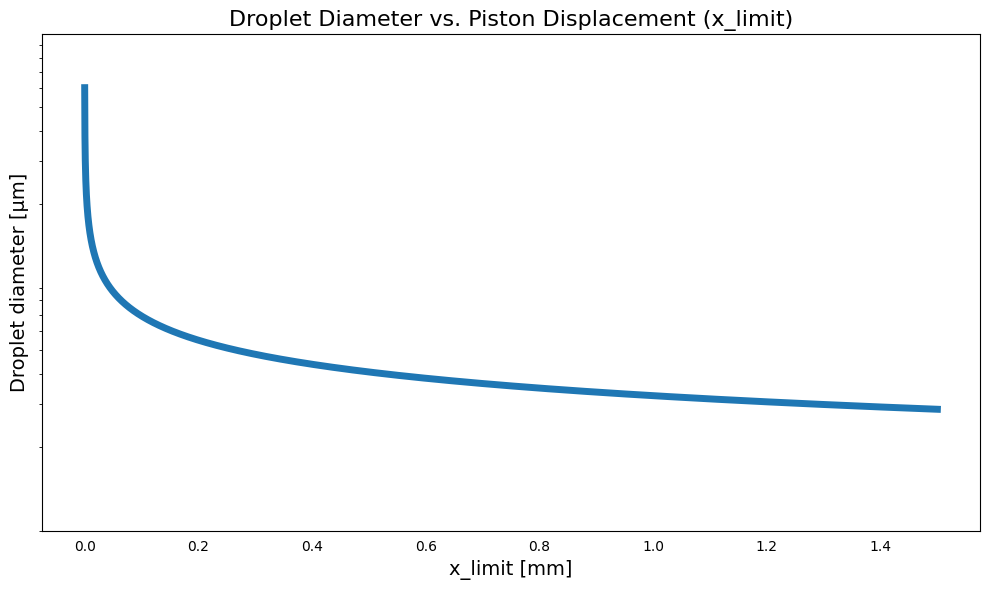

In [23]:
# Re-execute after reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 고정 변수들
m = 0.02
D1 = 2.4 * 1e-3
D2 = 0.2 * 1e-3
L1 = 20.87 * 1e-3
L2 = 5.0 * 1e-3
k1 = 2660
k2 = 1260
L_open = 1.0 * 1e-3
t_final = 0.1
F_finger = 20

K = 0.9
f_pipe = 0.03
A_in = (np.pi / 4) * D1**2
rho = 1000
g = 9.81
sigma = 0.0728
f_gap = 0.3
E = 1e9
delta_gap = 0.001 * 1e-3
h_packing = 1 * 1e-3

k = (k1 * k2) / (k1 + k2)

# D_chamber 고정
D_chamber = 0.01 #m 단위
A_chamber = (np.pi / 4) * D_chamber**2

# x_limit 변화 범위
x_limits = np.linspace(0, 0.0015, 10000)

v_avg_array = []
t_stop_array = []
We_array = []
D_particle_array = []

for x_limit in x_limits:
    c = (rho * 1.0 * A_chamber) / 2

    def force(t):
        return F_finger

    def mck_system(t, y):
        x, v = y
        dxdt = v
        dvdt = (force(t) - c * v - k * x) / m
        return [dxdt, dvdt]

    def reach_stroke_limit(t, y):
        return y[0] - x_limit
    reach_stroke_limit.terminal = True
    reach_stroke_limit.direction = 1

    y0 = [0.0, 0.0]
    t_span = (0, t_final)
    t_eval = np.linspace(t_span[0], t_span[1], 1000)

    sol = solve_ivp(
        mck_system,
        t_span,
        y0,
        t_eval=t_eval,
        events=reach_stroke_limit
    )

    v = sol.y[1]
    v_avg = np.mean(v)
    v_avg_array.append(v_avg)

    t_stop = sol.t_events[0][0] if len(sol.t_events[0]) > 0 else t_final
    t_stop_array.append(t_stop)

    # Weber 수 계산
    geom_term = np.sqrt((1 - f_pipe * L1 / D1) * (1 - K) * (1 - f_pipe * L2 / D2))
    A_term = ((rho * D2 / sigma) * ((A_chamber / A_in) * geom_term))**2

    F_friction = 2 * np.pi * f_gap * E * delta_gap * h_packing
    A_wall = np.pi * D_chamber * x_limit
    F_muf = A_wall * (f_pipe * (x_limit / D_chamber) * (1 / (2 * g)) * v_avg**2)
    F_open = k1 * L_open
    F_total = F_finger - F_friction - F_muf - F_open
    B_term = max(F_total, 0)**2

    c_val = (rho * v_avg * A_chamber) / 2
    zeta = c_val / (2 * np.sqrt(m * k2))
    omega_n = np.sqrt(k2 / m)
    omega_d = omega_n * np.sqrt(1 - zeta**2)

    exp_term = np.exp(-zeta * omega_n * t_stop)
    dyn_term = (
        zeta * omega_n * (np.cos(omega_d * t_stop) + (zeta * omega_n / omega_d) * np.sin(omega_d * t_stop))
        - omega_d * (-np.sin(omega_d * t_stop) + (zeta * omega_n / omega_d) * np.cos(omega_d * t_stop))
    )
    C_term = ((exp_term / k2)**2) * (dyn_term**2)

    We = A_term * B_term * C_term
    We_array.append(We)

    D_particle = 1.95 * D2 * (1.293 / rho)**(-1/6) * (We**(-1/3))
    D_particle_array.append(D_particle)
#
lw = 5

# 그래프 출력
plt.figure(figsize=(10, 6))
plt.plot(x_limits*1000, We_array, lw=lw)
plt.xlabel('x_limit [mm]',fontsize=14)
plt.ylabel('Weber Number (We)',fontsize=14)
plt.title('Weber Number vs. Piston Displacement (x_limit)',fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.yticks([])  # y축 눈금 제거
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x_limits*1000, np.array(D_particle_array) * 1e6 , lw=lw)
plt.xlabel('x_limit [mm]',fontsize=14)
plt.ylabel('Droplet diameter [μm]',fontsize=14)
plt.title('Droplet Diameter vs. Piston Displacement (x_limit)',fontsize=16)
plt.yscale("log")
plt.ylim(90, 10000)
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.yticks([])  # y축 눈금 제거
plt.tight_layout()
plt.show()
